## SQL 에이전트

이 튜토리얼에서는 LangGraph를 사용하여 SQL 데이터베이스에 대한 질문에 답변할 수 있는 사용자 지정 에이전트를 구축합니다. LangGraph 기본 요소를 사용하여 SQL 에이전트의 구현 예시를 보여줍니다. 

LangChain은 LangGraph 기본 요소를 사용하여 구현된 내장 에이전트 구현체를 제공합니다. 상위 수준의 LangChain 추상화를 사용하여 SQL 에이전트를 구축하는 튜토리얼은 [여기](https://docs.langchain.com/oss/python/langchain/sql-agent)에서 확인할 수 있습니다.

랭그래프 공식 튜토리얼 참고: https://docs.langchain.com/oss/python/langgraph/sql-agent

## 환경 설정

In [ ]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

In [ ]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1-mini")

## 데이터베이스 구성

SQLite 데이터베이스를 생성합니다. 공개 GCS 버킷에서 Chinook.db 데이터베이스 파일을 다운로드 합니다.

In [2]:
import requests
import pathlib

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
local_path = pathlib.Path("temp", "Chinook.db")

if local_path.exists():
    print(f"{local_path} already exists, skipping download.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        local_path.write_bytes(response.content)
        print(f"File downloaded and saved as {local_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as temp/Chinook.db


데이터베이스와 상호작용하기 위해 langchain_community 패키지에서 제공하는 SQLDatabase 래퍼를 사용합니다. SQLDatabase는 SQL 쿼리를 실행하고 결과를 가져오는 간단한 인터페이스를 제공합니다.

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(f"sqlite:///{local_path}")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f"Sample output: {db.run('SELECT * FROM Artist LIMIT 5;')}")

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


## 데이터베이스 상호작용을 위한 도구 추가

이번에도 langchain_community 패키지에서 제공하는 SQLDatabaseToolkit 래퍼를 사용하여 데이터베이스와 상호작용합니다.

In [12]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"* {tool.name}: {tool.description}\n")

* sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

* sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

* sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

* sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## 노드 정의

다음 단계들을 위한 노드를 구성합니다:

- DB 테이블 목록 생성
- `get schema` 도구 호출
- 쿼리 생성
- 쿼리 검증

이러한 단계들을 노드에 배치함으로써 (1) 필요 시 도구 호출을 강제하고, (2) 각 단계와 연관된 프롬프트를 맞춤 설정할 수 있습니다.

In [ ]:
from langgraph.prebuilt import ToolNode

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


In [ ]:
from langchain_core.messages import AIMessage
from langgraph.graph import MessagesState


def list_tables(state: MessagesState):
    result = list_tables_tool.invoke({})
    return {"messages": [AIMessage(f"Available tables: {result}")]}

In [83]:
list_tables({})

{'messages': [AIMessage(content='Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', additional_kwargs={}, response_metadata={})]}

In [84]:
def call_get_schema(state: MessagesState):
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="required")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [85]:
response = call_get_schema({"messages": [("user", "Album 테이블 정보는?")]})
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_8Kyf4HB8UINOYEnCVa9S1a2o)
 Call ID: call_8Kyf4HB8UINOYEnCVa9S1a2o
  Args:
    table_names: Album


In [86]:
generate_query_system_prompt_template = """
당신은 SQL 데이터베이스와 상호작용하도록 설계된 에이전트입니다.
입력된 질문을 받아 구문적으로 올바른 {dialect} 쿼리를 생성하여 실행한 후,
쿼리 결과를 확인하고 답변을 반환하십시오. 사용자가 원하는 예시 수를 명시하지 않는 한,
쿼리 결과를 항상 최대 {top_k}개로 제한하십시오.

관련 열로 결과를 정렬하여 데이터베이스에서 가장 흥미로운 예시를 반환할 수 있습니다. 특정 테이블의 모든 열을 쿼리하지 말고, 질문에 주어진 관련 열만 요청하십시오.

데이터베이스에 대한 DML 쿼리문(INSERT, UPDATE, DELETE, DROP 등)을 절대 실행하지 마십시오.
"""


def generate_query(state: MessagesState):
    llm_with_tools = llm.bind_tools([run_query_tool])
    generate_query_system_prompt = generate_query_system_prompt_template.format(
        dialect=db.dialect,
        top_k=5,
    )
    response = llm_with_tools.invoke(
        [("system", generate_query_system_prompt)] + state["messages"]
    )
    return {"messages": [response]}

In [87]:
response = generate_query(
    {"messages": [("user", "평균적으로 어떤 장르의 트랙이 가장 길까?")]}
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_p1dmTHC6p5a3XOASlmt8NjXl)
 Call ID: call_p1dmTHC6p5a3XOASlmt8NjXl
  Args:
    query: SELECT g.Name AS Genre, AVG(t.Milliseconds) / 60000.0 AS AverageLengthMinutes FROM tracks t JOIN genres g ON t.GenreId = g.GenreId GROUP BY g.Name ORDER BY AverageLengthMinutes DESC LIMIT 5;


In [ ]:
check_query_system_prompt_template = """
세부 사항에 대한 주의력이 뛰어난 SQL 전문가입니다.
{dialect} 쿼리에서 다음과 같은 일반적인 오류를 다시 한번 확인하십시오:
- NULL 값과 함께 NOT IN 사용
- UNION ALL을 사용해야 할 때 UNION 사용
- 배제 범위에 BETWEEN 사용
- 술어 내 데이터 유형 불일치
- 식별자 올바른 따옴표 처리
- 함수에 올바른 개수의 인자 사용
- 올바른 데이터 유형으로 캐스팅
- 조인에 적합한 열 사용

위 오류가 발견되면 쿼리를 재작성하십시오. 오류가 없으면
원본 쿼리를 그대로 복제하십시오.

이 검사를 수행한 후 적절한 도구를 호출하여 쿼리를 실행하십시오.
"""


def check_query(state: MessagesState):
    check_query_system_prompt = check_query_system_prompt_template.format(
        dialect=db.dialect
    )
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = ("user", tool_call["args"]["query"])
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="required")
    response = llm_with_tools.invoke(
        [
            ("system", check_query_system_prompt),
            ("user", user_message),
        ]
    )
    return {"messages": [response]}

In [89]:
check_query({"messages": response["messages"]})

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5MMyMuZGsGtqi2ZbzVxCt388', 'function': {'arguments': '{"query":"SELECT g.Name AS Genre, AVG(t.Milliseconds) / 60000.0 AS AverageLengthMinutes FROM tracks t JOIN genres g ON t.GenreId = g.GenreId GROUP BY g.Name ORDER BY AverageLengthMinutes DESC LIMIT 5;"}', 'name': 'sql_db_query'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 347, 'total_tokens': 412, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CQWS1vJRivywZ9XxSYoTX9eVgV3L6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9dfb1099-a00f-4ed1-a6a9-0b0a2cd97c10-0', tool_calls=[{'name': 'sql_db_

## 에이전트 구현

쿼리 생성 단계에서 조건부 에지를 정의하여 쿼리가 생성되면 쿼리 검사기로 라우팅하고, 툴 호출이 존재하지 않으면 종료합니다. 

In [99]:
from typing import Literal
from langgraph.graph import StateGraph, END


def should_continue(state: MessagesState) -> Literal["check_query", END]:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "check_query"
    else:
        return END

In [100]:
builder = StateGraph(MessagesState)
builder.add_node(list_tables)  # 테이블 목록 조회
builder.add_node(call_get_schema)  # 테이블 스키마 정보 조회 도구 요청
builder.add_node("get_schema", get_schema_node)  # 테이블 스키마 정보 도구 사용
builder.add_node(generate_query)  # 쿼리문 작성
builder.add_node(check_query)  # 쿼리문 검증
builder.add_node("run_query", run_query_node)  # 쿼리문 실행 도구 요청

builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

builder.set_entry_point("list_tables")
agent = builder.compile()

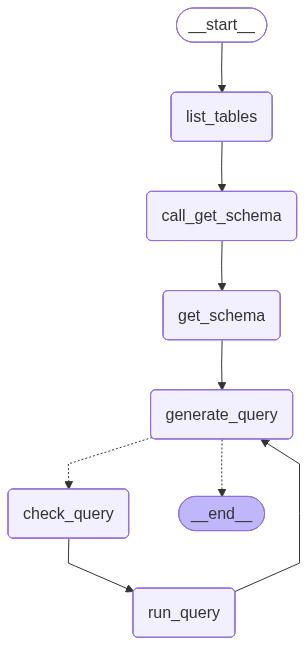

In [101]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [102]:
question = "평균적으로 어떤 장르의 트랙이 가장 길까?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

평균적으로 어떤 장르의 트랙이 가장 길까?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_uxrKZY7XnlprgPyCEISc5UFv)
 Call ID: call_uxrKZY7XnlprgPyCEISc5UFv
  Args:
    table_names: Track, Genre
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"M

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_TctkDBxkngoA8QfZqv3qo9qp", 'type': 'invalid_request_error', 'param': 'messages.[6].role', 'code': None}}